**`1. Importer les dépendances`**

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os, glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [48]:
import kagglehub

path = kagglehub.dataset_download("emirhanai/planets-and-moons-dataset-ai-in-space")
print("Dataset téléchargé ici :", path)



Using Colab cache for faster access to the 'planets-and-moons-dataset-ai-in-space' dataset.
Dataset téléchargé ici : /kaggle/input/planets-and-moons-dataset-ai-in-space


In [49]:
selected_classes = ["Earth", "Jupiter","Mars", "Neptune", "Pluto", "Venus"]


In [50]:

import os
import shutil

src_base = "/kaggle/input/planets-and-moons-dataset-ai-in-space/Planets_Moons_Data/Planets and Moons"
dst_base = "/content/planets_selected"

os.makedirs(dst_base, exist_ok=True)

for cls in selected_classes:
    src = os.path.join(src_base, cls)
    dst = os.path.join(dst_base, cls)

    if os.path.exists(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
        print(f"Copié : {cls}")
    else:
        print(f"Introuvable : {cls}")


Copié : Earth
Copié : Jupiter
Copié : Mars
Copié : Neptune
Copié : Pluto
Copié : Venus


**`2. Lister toutes les images + labels`**

In [51]:
import glob
import os

dataset_path = "/content/planets_selected"

image_paths = []
labels = []

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    for img in glob.glob(cls_path + "/*"):
        image_paths.append(img)
        labels.append(cls)

print("Total images :", len(image_paths))
print("Classes :", set(labels))


Total images : 894
Classes : {'Jupiter', 'Venus', 'Earth', 'Pluto', 'Mars', 'Neptune'}


In [52]:
from skimage.io import imread

img = imread("/content/planets_selected/Neptune/Neptune (1).jpg")
print("Shape de l'image :", img.shape)


Shape de l'image : (144, 256, 3)


**`3. Split train / test (80% / 20%)`**

- Nous séparons l’ensemble des données en un jeu d’entraînement et un jeu de test, avec 90 % des données pour l’entraînement et 10 % pour le test

In [53]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.1, random_state=42, stratify=labels
)


**`4. Split train (train & val (80% train / 20% val))`**

Nous divisons ensuite le jeu d’entraînement en 80% pour l’apprentissage et 10% pour la validation, ce qui permet d’ajuster les paramètres du modèle tout en évitant le sur-apprentissage.

In [54]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1111, random_state=42, stratify=train_labels
)


In [55]:
print("Train =", len(train_paths))
print("Val   =", len(val_paths))
print("Test  =", len(test_paths))


Train = 714
Val   = 90
Test  = 90


- Nous vérifions l’équilibre des classes dans chaque ensemble afin de garantir une répartition homogène des données.

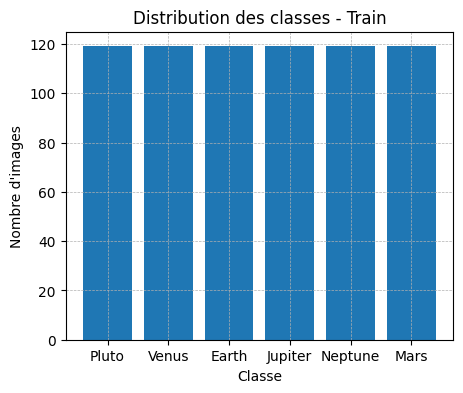

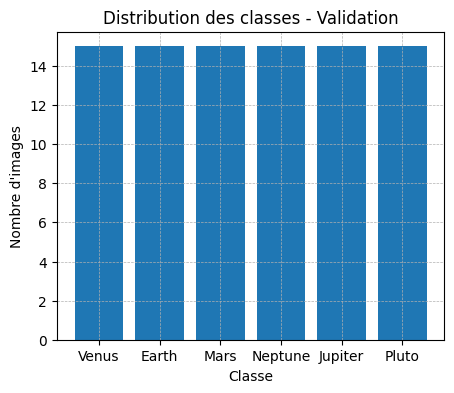

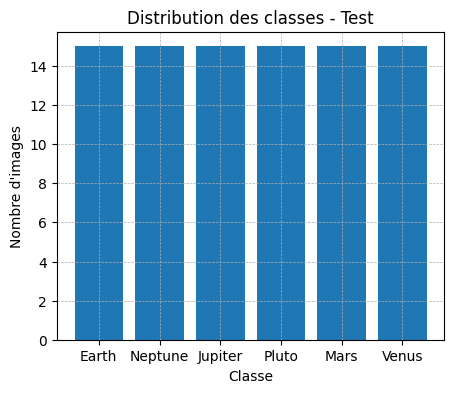

In [56]:
import matplotlib.pyplot as plt
from collections import Counter

# Fonction pour tracer un barplot
def plot_distribution(labels, title):
    counts = Counter(labels)

    classes = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(5, 4))
    plt.bar(classes, values)
    plt.title(title)
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'images")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.show()


# Graphique pour train
plot_distribution(train_labels, "Distribution des classes - Train")

# Graphique pour validation
plot_distribution(val_labels, "Distribution des classes - Validation")

# Graphique pour test
plot_distribution(test_labels, "Distribution des classes - Test")


**`5. Create Dataset PyTorch pour Train / Val / Test`**

- Dans cette étape, nous définissons une classe personnalisée PlanetDataset héritée de torch.utils.data.Dataset afin de gérer le chargement des images et des étiquettes dans PyTorch.
Cette classe permet d’associer chaque image à son label, de convertir les images au format RGB et d’appliquer des transformations si nécessaire.
Elle est ensuite utilisée pour créer les datasets d’entraînement, de validation et de test, facilitant ainsi l’intégration avec les DataLoaders pour l’apprentissage du modèle.

In [57]:
from torch.utils.data import Dataset
from PIL import Image

class PlanetDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.class_to_idx = {c:i for i,c in enumerate(sorted(set(labels)))}
        self.idx_to_class = {v:k for k,v in self.class_to_idx.items()}

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.class_to_idx[self.labels[idx]]

        if self.transform:
            img = self.transform(img)

        return img, label


**`6. Transforms`**

In [58]:
img_size = 224

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])


**`7. DataLoaders`**

- Dans cette étape, nous créons les DataLoaders PyTorch à partir des datasets d’entraînement, de validation et de test que nous avons définis précédemment.
Nous utilisons un mélange aléatoire des données pour l’ensemble d’entraînement, afin d’améliorer la capacité de généralisation du modèle, tandis que nous conservons un chargement ordonné pour les ensembles de validation et de test, garantissant une évaluation cohérente et reproductible.
Grâce à cette organisation, nous assurons un chargement efficace des données par mini-lots (batchs) lors des phases d’apprentissage et d’évaluation.

In [59]:
train_dataset = PlanetDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = PlanetDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset  = PlanetDataset(test_paths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = sorted(set(labels))
print(classes)


['Earth', 'Jupiter', 'Mars', 'Neptune', 'Pluto', 'Venus']


**`8. Modeles`**

- Dans cette partie, nous considérons deux architectures de modèles différentes pour la classification des planetes.
Le premier modèle est un réseau pré-entraîné de type ResNet-18, initialisé avec des poids appris sur ImageNet et utilisé pour notre dataset. Le second modèle est un réseau de neurones convolutif (CNN) personnalisé.
- Nous choisissons ensuite le modèle à entraîner en fonction des expériences menées et des performances obtenues.

**`- ResNet18 pré-entraîné`**



Dans un premier temps, nous avons entraîné le modèle ResNet-18, qui a montré de bonnes performances en termes de précision.
Toutefois, ce modèle comporte un nombre important de paramètres, ce qui implique un coût de calcul plus élevé et une complexité accrue lors de l’entraînement et du déploiement.

In [60]:
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device :", device)

model = models.resnet18(weights="IMAGENET1K_V1")

# remplacer le FC (1000 → nombre de classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(classes))

model1 = model.to(device)
from torchsummary import summary

summary(model, input_size=(3, 224, 224))  # adapte selon ton dataset


Device : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14     

**`- Modele personalisé`**

- Nous avons ensuite exploré un modèle CNN personnalisé, plus léger et comportant moins de paramètres, afin de réduire la complexité du modèle tout en conservant les memes performances .

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        #self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        #self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, num_classes)

        #self.fc1 = nn.Linear(128 * 28 * 28, 256)
        #self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

**`9. Définir Loss + Optimizer`**

In [62]:
import torch
from torchsummary import summary
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

# ==== Ton modèle ====
model = MyCNN(num_classes=len(classes)).to(device)

# ==== Affichage du summary ====
summary(model, (3, 224, 224))




Device utilisé : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Linear-5                   [-1, 32]       6,422,560
            Linear-6                    [-1, 6]             198
Total params: 6,442,150
Trainable params: 6,442,150
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 22.97
Params size (MB): 24.57
Estimated Total Size (MB): 48.12
----------------------------------------------------------------


In [63]:
import torch.nn as nn

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)


- Pour l’entraînement du modèle, nous utilisons la fonction de perte CrossEntropyLoss, adaptée aux problèmes de classification multi-classes.
L’optimisation des paramètres est assurée par l’optimiseur Adam, avec un taux d’apprentissage fixé à 0,0001, permettant une convergence efficace et stable du modèle.

In [64]:
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


**`10. Entraînement avec validation`**

In [65]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs =30

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # TRAIN
    model.train()
    train_loss = 0
    train_correct = 0
    total_train = 0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += lbls.size(0)
        train_correct += predicted.eq(lbls).sum().item()

    train_acc = 100 * train_correct / total_train
    train_loss /= len(train_loader)

    # VALIDATION
    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, lbls)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += lbls.size(0)
            val_correct += predicted.eq(lbls).sum().item()

    val_acc = 100 * val_correct / total_val
    val_loss /= len(val_loader)

    #  Sauvegarde pour les courbes
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Acc={train_acc:.2f}% | Train Loss={train_loss:.4f} | "
          f"Val Acc={val_acc:.2f}% | Val Loss={val_loss:.4f}")


Epoch 1/30 | Train Acc=61.48% | Train Loss=1.2343 | Val Acc=91.11% | Val Loss=0.7126
Epoch 2/30 | Train Acc=96.92% | Train Loss=0.3871 | Val Acc=98.89% | Val Loss=0.2022
Epoch 3/30 | Train Acc=99.44% | Train Loss=0.1004 | Val Acc=98.89% | Val Loss=0.1190
Epoch 4/30 | Train Acc=99.58% | Train Loss=0.0471 | Val Acc=98.89% | Val Loss=0.0976
Epoch 5/30 | Train Acc=99.58% | Train Loss=0.0284 | Val Acc=98.89% | Val Loss=0.0732
Epoch 6/30 | Train Acc=99.72% | Train Loss=0.0208 | Val Acc=98.89% | Val Loss=0.0943
Epoch 7/30 | Train Acc=99.58% | Train Loss=0.0222 | Val Acc=98.89% | Val Loss=0.0650
Epoch 8/30 | Train Acc=99.58% | Train Loss=0.0161 | Val Acc=98.89% | Val Loss=0.0386
Epoch 9/30 | Train Acc=99.86% | Train Loss=0.0107 | Val Acc=98.89% | Val Loss=0.0339
Epoch 10/30 | Train Acc=99.86% | Train Loss=0.0072 | Val Acc=98.89% | Val Loss=0.0288
Epoch 11/30 | Train Acc=99.72% | Train Loss=0.0104 | Val Acc=98.89% | Val Loss=0.0262
Epoch 12/30 | Train Acc=99.72% | Train Loss=0.0066 | Val Acc=98

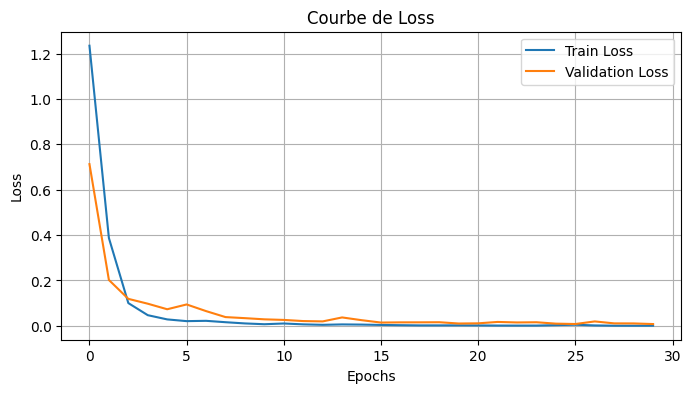

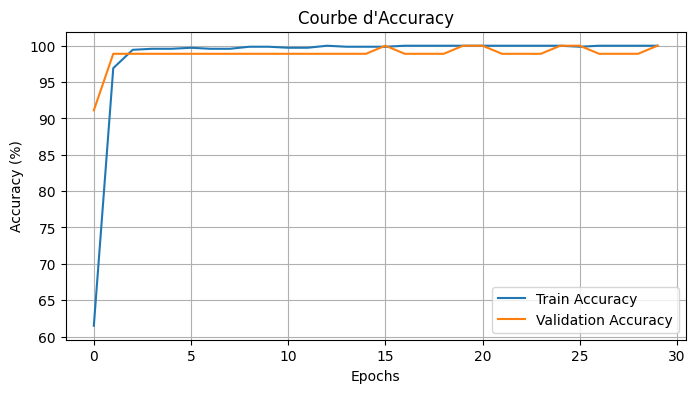

In [66]:
import matplotlib.pyplot as plt

# --- Courbe de LOSS ---
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbe de Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Courbe d'ACCURACY ---
plt.figure(figsize=(8,4))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Courbe d'Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [67]:
import torch
from sklearn.metrics import accuracy_score

# ----- TEST DU MODELE -----
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(lbls.numpy())

# ----- ACCURACY -----
accuracy = accuracy_score(all_labels, all_preds)

print(f"Accuracy du modèle sur le test set : {accuracy*100:.2f}%")


Accuracy du modèle sur le test set : 100.00%


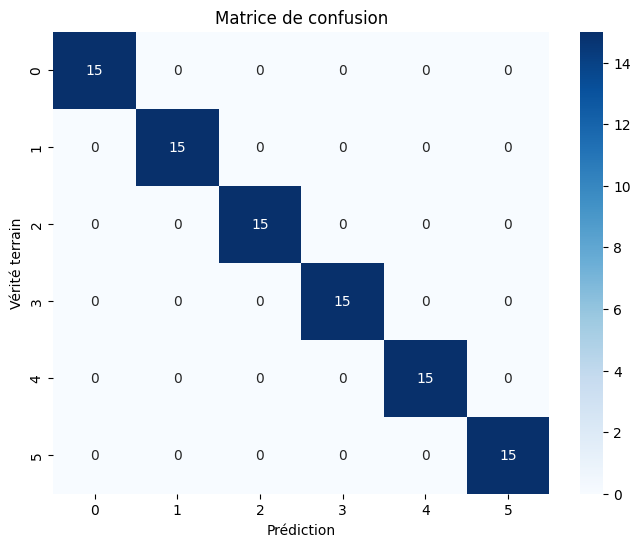

In [68]:
from sklearn.metrics import confusion_matrix
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# ----- MATRICE DE CONFUSION (COMPLET EN UNE CELLULE) -----
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(lbls.numpy())

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)

# Affichage
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion")
plt.show()


In [69]:
import pandas as pd
from sklearn.metrics import classification_report

# Générer le rapport sklearn en dictionnaire
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)

# Construire les lignes du tableau
rows = []

# Ajouter chaque classe
for cls in classes:
    rows.append([
        cls,
        round(report[cls]["precision"], 2),
        round(report[cls]["recall"], 2),
        round(report[cls]["f1-score"], 2),
        report[cls]["support"]
    ])

# Ajouter macro avg
total_support = sum(report[cls]["support"] for cls in classes)

rows.append([
    "Macro",
    round(report["macro avg"]["precision"], 2),
    round(report["macro avg"]["recall"], 2),
    round(report["macro avg"]["f1-score"], 2),
    total_support
])

# Créer tableau pandas
df = pd.DataFrame(rows, columns=["Classe", "Précision", "Rappel", "F1-Score", "Support"])

# Mettre la dernière ligne en gras dans l'affichage HTML
df.style.set_properties(**{'text-align': 'center'}) \
    .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) \
    .apply(lambda row: ['font-weight: bold' if row.name == len(df)-1 else '' for _ in row], axis=1)


,Classe,Précision,Rappel,F1-Score,Support
0,Earth,1.000000,1.000000,1.000000,15.000000
1,Jupiter,1.000000,1.000000,1.000000,15.000000
2,Mars,1.000000,1.000000,1.000000,15.000000
3,Neptune,1.000000,1.000000,1.000000,15.000000
4,Pluto,1.000000,1.000000,1.000000,15.000000
5,Venus,1.000000,1.000000,1.000000,15.000000
6,Macro,1.000000,1.000000,1.000000,90.000000
